In [1]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

/Users/lucasrea/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/lucasrea/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
"""
Defining some constants for data mining
"""

NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'SPY'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

[*********************100%***********************]  1 of 1 completed
                open      high       low     close  Adj Close  volume
Date                                                                 
1993-04-01  45.25000  45.25000  44.93750  45.03125  26.962603  129500
1993-04-02  44.65625  44.65625  44.09375  44.09375  26.401272   59400
1993-04-05  44.43750  44.43750  44.18750  44.31250  26.532251  172200
1993-04-06  44.40625  44.40625  44.06250  44.18750  26.457396  129700
1993-04-07  44.25000  44.34375  44.15625  44.34375  26.550953   28000


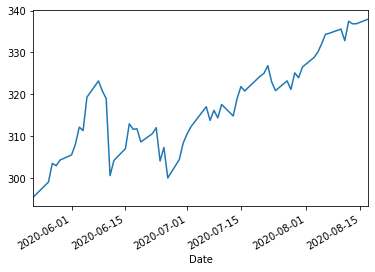

In [3]:
"""
Next we pull the historical data using yfinance
Rename the column names because finta uses the lowercase names
"""

start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(data.head())

tmp = data.iloc[-60:]
tmp['close'].plot()

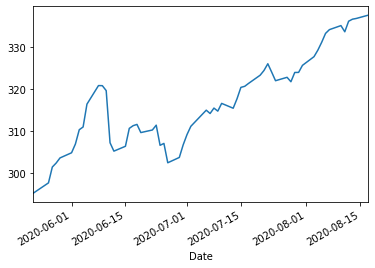

In [4]:
"""
Next we clean our data and perform feature engineering to create new technical indicator features that our
model can learn from
"""

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['close'].plot()

In [5]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])
    
    return data

data = _get_indicator_data(data)
print(data.columns)

Index(['close', 'RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV_x', 'OBV_y',
       '20 period CCI', '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21',
       'ema15', 'ema5', 'normVol'],
      dtype='object')


In [6]:
live_pred_data = data.iloc[-16:-11]

In [7]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()

,RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV_x,...,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-21,81.899831,4.524785,3.800155,92.006271,4.699796e+11,4.688549,10.200018,85.124272,4.252876,5.803983e+07,...,112.239475,19.183981,-13.581844,24.886308,1.072459,1.048511,1.036013,1.017142,0.800881,1.0
2020-07-22,84.309923,4.785621,3.997248,95.515552,4.700897e+11,4.609482,10.512001,84.787112,3.494783,5.787933e+07,...,109.007427,19.299208,-15.572880,26.925803,1.076096,1.051106,1.038265,1.018387,0.826396,1.0
2020-07-23,70.835258,4.777788,4.153356,80.490223,4.701647e+11,4.609677,9.256192,77.619173,3.125323,-6.948746e+07,...,88.240670,19.648506,-10.304071,15.678750,1.068115,1.042614,1.029776,1.010157,0.993438,1.0
2020-07-24,59.490511,4.554172,4.233519,67.379897,4.702473e+11,4.502336,5.378173,70.480595,2.057752,-7.226890e+07,...,58.848070,19.786100,-14.950115,18.770667,1.060103,1.034343,1.021695,1.003153,1.027517,1.0
2020-07-27,62.241352,4.391348,4.265085,72.548453,4.703561e+11,4.447787,7.329364,77.681752,2.547333,5.668457e+07,...,57.078508,19.897446,-19.023992,23.675037,1.061449,1.035194,1.022598,1.004715,0.832878,1.0


In [8]:
def _split_data(data):

    """
    Function to partition the data into the train and test set
    :return:
    """

    y = data['pred']
    features = [x for x in data.columns if x not in ['pred']]
    X = data[features]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 4 * len(X) // 5)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = _split_data(data)
print('X Train : ' + str(len(X_train)))
print('X Test  : ' + str(len(X_test)))
print('y Train : ' + str(len(y_train)))
print('y Test  : ' + str(len(y_test)))


X Train : 5492
X Test  : 1374
y Train : 5492
y Test  : 1374


In [9]:
"""
Next we create and train our random forest classifier
"""

def _train_random_forest(X_train, y_train, X_test, y_test):

    """
    Function that uses random forest classifier to train the model
    :return:
    """
    
    # Create a new random forest classifier
    rf = RandomForestClassifier()
    
    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    
    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    
    # Fit model to training data
    rf_gs.fit(X_train, y_train)
    
    # Save best model
    rf_best = rf_gs.best_estimator_
    
    # Check best n_estimators value
    print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best
    
rf_model = _train_random_forest(X_train, y_train, X_test, y_test)

{'n_estimators': 180}
              precision    recall  f1-score   support

         0.0       0.91      0.69      0.78       513
         1.0       0.84      0.96      0.89       861

    accuracy                           0.86      1374
   macro avg       0.87      0.82      0.84      1374
weighted avg       0.86      0.86      0.85      1374

[[354 159]
 [ 37 824]]


In [10]:
def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 25)}
    
    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    
    # Fit model to training data
    knn_gs.fit(X_train, y_train)
    
    # Save best model
    knn_best = knn_gs.best_estimator_
     
    # Check best n_neigbors value
    print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return knn_best
    
    
knn_model = _train_KNN(X_train, y_train, X_test, y_test)

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84       513
         1.0       0.91      0.90      0.90       861

    accuracy                           0.88      1374
   macro avg       0.87      0.87      0.87      1374
weighted avg       0.88      0.88      0.88      1374

[[436  77]
 [ 87 774]]


In [11]:
def _train_ada_boost(X_train, y_train, X_test, y_test):
    
    ada = AdaBoostClassifier()
    
    params_ada = {'n_estimators': [110,130,140,150,160,180,200]}
    
    # Use gridsearch to test all values for n_neighbors
    grid_search = GridSearchCV(ada, params_ada, cv=5)
    
    grid_search.fit(X_train, y_train)
    
    ada_best = grid_search.best_estimator_
    
    # Save best model
    print(grid_search.best_params_)
    
    prediction = ada_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    return ada_best
    
ada_model = _train_ada_boost(X_train, y_train, X_test, y_test)


{'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.66      0.44      0.52       513
         1.0       0.72      0.86      0.79       861

    accuracy                           0.70      1374
   macro avg       0.69      0.65      0.66      1374
weighted avg       0.70      0.70      0.69      1374

[[224 289]
 [117 744]]


In [12]:
def _train_GBT(X_train, y_train, X_test, y_test):
    
    clf = GradientBoostingClassifier()
    
    # Dictionary of parameters to optimize
    params_gbt = {'n_estimators' :[150,160,170,180] , 'learning_rate' :[0.2,0.1,0.09] }
    
    # Use gridsearch to test all values for n_neighbors
    grid_search = GridSearchCV(clf, params_gbt, cv=5)
    
    # Fit model to training data
    grid_search.fit(X_train, y_train)
    
    gbt_best = grid_search.best_estimator_
    
    # Save best model
    print(grid_search.best_params_)
    
    prediction = gbt_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    
    return gbt_best


gbt_model = _train_GBT(X_train, y_train, X_test, y_test)

{'learning_rate': 0.2, 'n_estimators': 180}
              precision    recall  f1-score   support

         0.0       0.83      0.67      0.74       513
         1.0       0.82      0.92      0.87       861

    accuracy                           0.83      1374
   macro avg       0.83      0.79      0.81      1374
weighted avg       0.83      0.83      0.82      1374

[[343 170]
 [ 69 792]]


In [13]:
def _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test):
    
    # Create a dictionary of our models
    estimators=[('knn', knn_model), ('rf', rf_model), ('gbt', gbt_model)]
    
    # Create our voting classifier, inputting our models
    ensemble = VotingClassifier(estimators, voting='hard')
    
    #fit model to training data
    ensemble.fit(X_train, y_train)
    
    #test our model on the test data
    print(ensemble.score(X_test, y_test))
    
    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return ensemble
    
ensemble_model = _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test)

0.8748180494905385
              precision    recall  f1-score   support

         0.0       0.89      0.75      0.82       513
         1.0       0.87      0.95      0.90       861

    accuracy                           0.87      1374
   macro avg       0.88      0.85      0.86      1374
weighted avg       0.88      0.87      0.87      1374

[[387 126]
 [ 46 815]]


In [14]:
# Before we produced the prediction data, we grabbed this small dataframe to use in actual testing
live_pred_data.head()

,close,RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,...,OBV_y,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-27,322.786162,62.241352,4.391348,4.265085,72.548453,4.703561e+11,4.447787,7.329364,77.681752,2.547333,...,3.528961e+10,57.078508,19.897446,-19.023992,23.675037,1.061449,1.035194,1.022598,1.004715,0.832878
2020-07-28,321.735666,56.472199,4.129935,4.238055,65.809537,4.703738e+11,4.391089,4.027777,71.670376,1.621396,...,3.523240e+10,50.953848,19.732249,-19.109458,24.336528,1.056793,1.030334,1.017962,1.001204,0.863557
2020-07-29,323.935480,64.436935,4.053543,4.201153,78.786355,4.704770e+11,4.242638,3.535215,78.862259,2.687747,...,3.528392e+10,66.832824,19.637692,-15.176922,20.587691,1.062685,1.035620,1.023223,1.006699,0.807568
2020-07-30,323.951412,64.491234,3.948768,4.150676,78.587058,4.706788e+11,4.174430,3.297814,72.547696,1.965178,...,3.534216e+10,55.464701,19.488042,-11.947883,15.474844,1.061431,1.033994,1.021688,1.005617,0.926386
2020-07-31,325.620987,70.024948,3.954865,4.111514,90.067492,4.710257e+11,3.998273,4.274227,72.205119,1.629438,...,3.541793e+10,70.253651,19.121452,-10.257410,12.788418,1.065504,1.037469,1.025111,1.008984,1.165356


In [15]:
del(live_pred_data['close'])
prediction = ensemble_model.predict(live_pred_data)
print(prediction)


[1. 1. 1. 1. 1.]
